In [8]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [9]:
item1_mst = pd.read_csv('ITEM_MST.txt', encoding='CP949', sep='|')
item2_mst = pd.read_csv('ITEM_MST2.txt', encoding='CP949', sep='|')
category_mst = pd.read_csv('CATEGORY_MST.txt', encoding='CP949', sep='|')
store_mst = pd.read_csv('STORE_MST.txt', encoding='CP949', sep='|')
event_mst = pd.read_csv('EVT_MST.txt', encoding='CP949', sep='|')
item_mst = pd.concat([item1_mst, item2_mst], axis=0, ignore_index=True)

In [10]:
full = pd.read_csv('full.csv', sep='|')
full['YMD_CD'] = pd.to_datetime(full['YMD_CD'].astype(str), format='%Y%m%d')

In [21]:
df = full[(full['ITEM_CD']==8801119241511) & (full['PRST_NO']==150008)]

In [17]:
df = df.set_index('YMD_CD')


KeyError: "None of ['YMD_CD'] are in the columns"

In [22]:
daily_case = df['SALE_QTY']

In [16]:
def create_sequence(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [75]:
seq_length = 7
X, y = create_sequence(daily_case, seq_length)

In [23]:
import holidays

# 요일 피처 추가
df['day_of_week'] = df['YMD_CD'].dt.dayofweek

# 주간, 금요일, 주말 및 공휴일 피처 추가
df['weekdays'] = df['day_of_week'].apply(lambda x: 1 if x < 4 else 0)
df['friday'] = df['day_of_week'].apply(lambda x: 1 if x == 4 else 0)
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 공휴일 피처 추가
kr_holidays = holidays.KR(years=[2023, 2024])
df['holiday'] = df['YMD_CD'].apply(lambda x: 1 if x in kr_holidays else 0)


<ipython-input-23-cc19682ee0f6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['YMD_CD'].dt.dayofweek
<ipython-input-23-cc19682ee0f6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekdays'] = df['day_of_week'].apply(lambda x: 1 if x < 4 else 0)
<ipython-input-23-cc19682ee0f6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [29]:
df['day_of_week'] = df['day_of_week'].astype('category')
df['weekdays'] = df['weekdays'].astype('category')
df['friday'] = df['friday'].astype('category')
df['weekend'] = df['weekend'].astype('category')
df['holiday'] = df['holiday'].astype('category')

<ipython-input-29-68cc75a01865>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['day_of_week'].astype('category')
<ipython-input-29-68cc75a01865>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekdays'] = df['weekdays'].astype('category')
<ipython-input-29-68cc75a01865>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 83876 to 49313732
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   YMD_CD       488 non-null    datetime64[ns]
 1   SMCL_CD      488 non-null    int64         
 2   PRST_NO      488 non-null    int64         
 3   ITEM_CD      488 non-null    int64         
 4   SALE_QTY     488 non-null    int64         
 5   day_of_week  488 non-null    category      
 6   weekdays     488 non-null    category      
 7   friday       488 non-null    category      
 8   weekend      488 non-null    category      
 9   holiday      488 non-null    category      
dtypes: category(5), datetime64[ns](1), int64(4)
memory usage: 26.1 KB


In [27]:
# 2023년까지의 데이터를 train_df로 분리
train_df = df[df['YMD_CD'].dt.year <= 2023]

# 2024년부터의 데이터를 test_df로 분리
test_df = df[df['YMD_CD'].dt.year >= 2024]

In [33]:
test_df.describe()

,SMCL_CD,PRST_NO,ITEM_CD,SALE_QTY,day_of_week,weekdays,friday,weekend,holiday
count,95.0,95.0,9.500000e+01,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,134.0,150008.0,8.801119e+12,7.431579,2.936842,0.589474,0.136842,0.273684,0.063158
std,0.0,0.0,0.000000e+00,5.953102,2.004307,0.494539,0.345504,0.448214,0.244537
min,134.0,150008.0,8.801119e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,134.0,150008.0,8.801119e+12,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,134.0,150008.0,8.801119e+12,6.000000,3.000000,1.000000,0.000000,0.000000,0.000000
75%,134.0,150008.0,8.801119e+12,13.000000,5.000000,1.000000,0.000000,1.000000,0.000000
max,134.0,150008.0,8.801119e+12,21.000000,6.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
scaler = MinMaxScaler()

In [35]:
# train_df의 SALE_QTY 스케일링
train_df['SALE_QTY'] = scaler.fit_transform(train_df[['SALE_QTY']])

# test_df의 SALE_QTY 스케일링
# train_df에서 학습한 스케일러를 사용하여 변환
test_df['SALE_QTY'] = scaler.transform(test_df[['SALE_QTY']])

<ipython-input-35-56e0add784ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['SALE_QTY'] = scaler.fit_transform(train_df[['SALE_QTY']])
<ipython-input-35-56e0add784ab>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['SALE_QTY'] = scaler.transform(test_df[['SALE_QTY']])


In [74]:
def make_Tensor(array):
    return torch.from_numpy(array).float()

In [ ]:
X_train = make_Tensor(train_df)


## STL 해보기

In [ ]:
store_mst[store_mst['PRST_NO']==150008]

,PRST_NO,STOR_NM,LCTN_TY_CD,LCTN_TY_NM,GUBUN,GUBUN_NM,OPRT_TIME_DIV_CD,STOR_SIZE_CD
20,150008,김해장유반딧불점,1,독신자주택,5,05.경상도,1,2


In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
ts = df[['SALE_QTY', 'YMD_CD']]
ts.set_index('YMD_CD', inplace=True)

In [72]:
# STL 분해
stl = STL(ts, seasonal=7)
result = stl.fit()

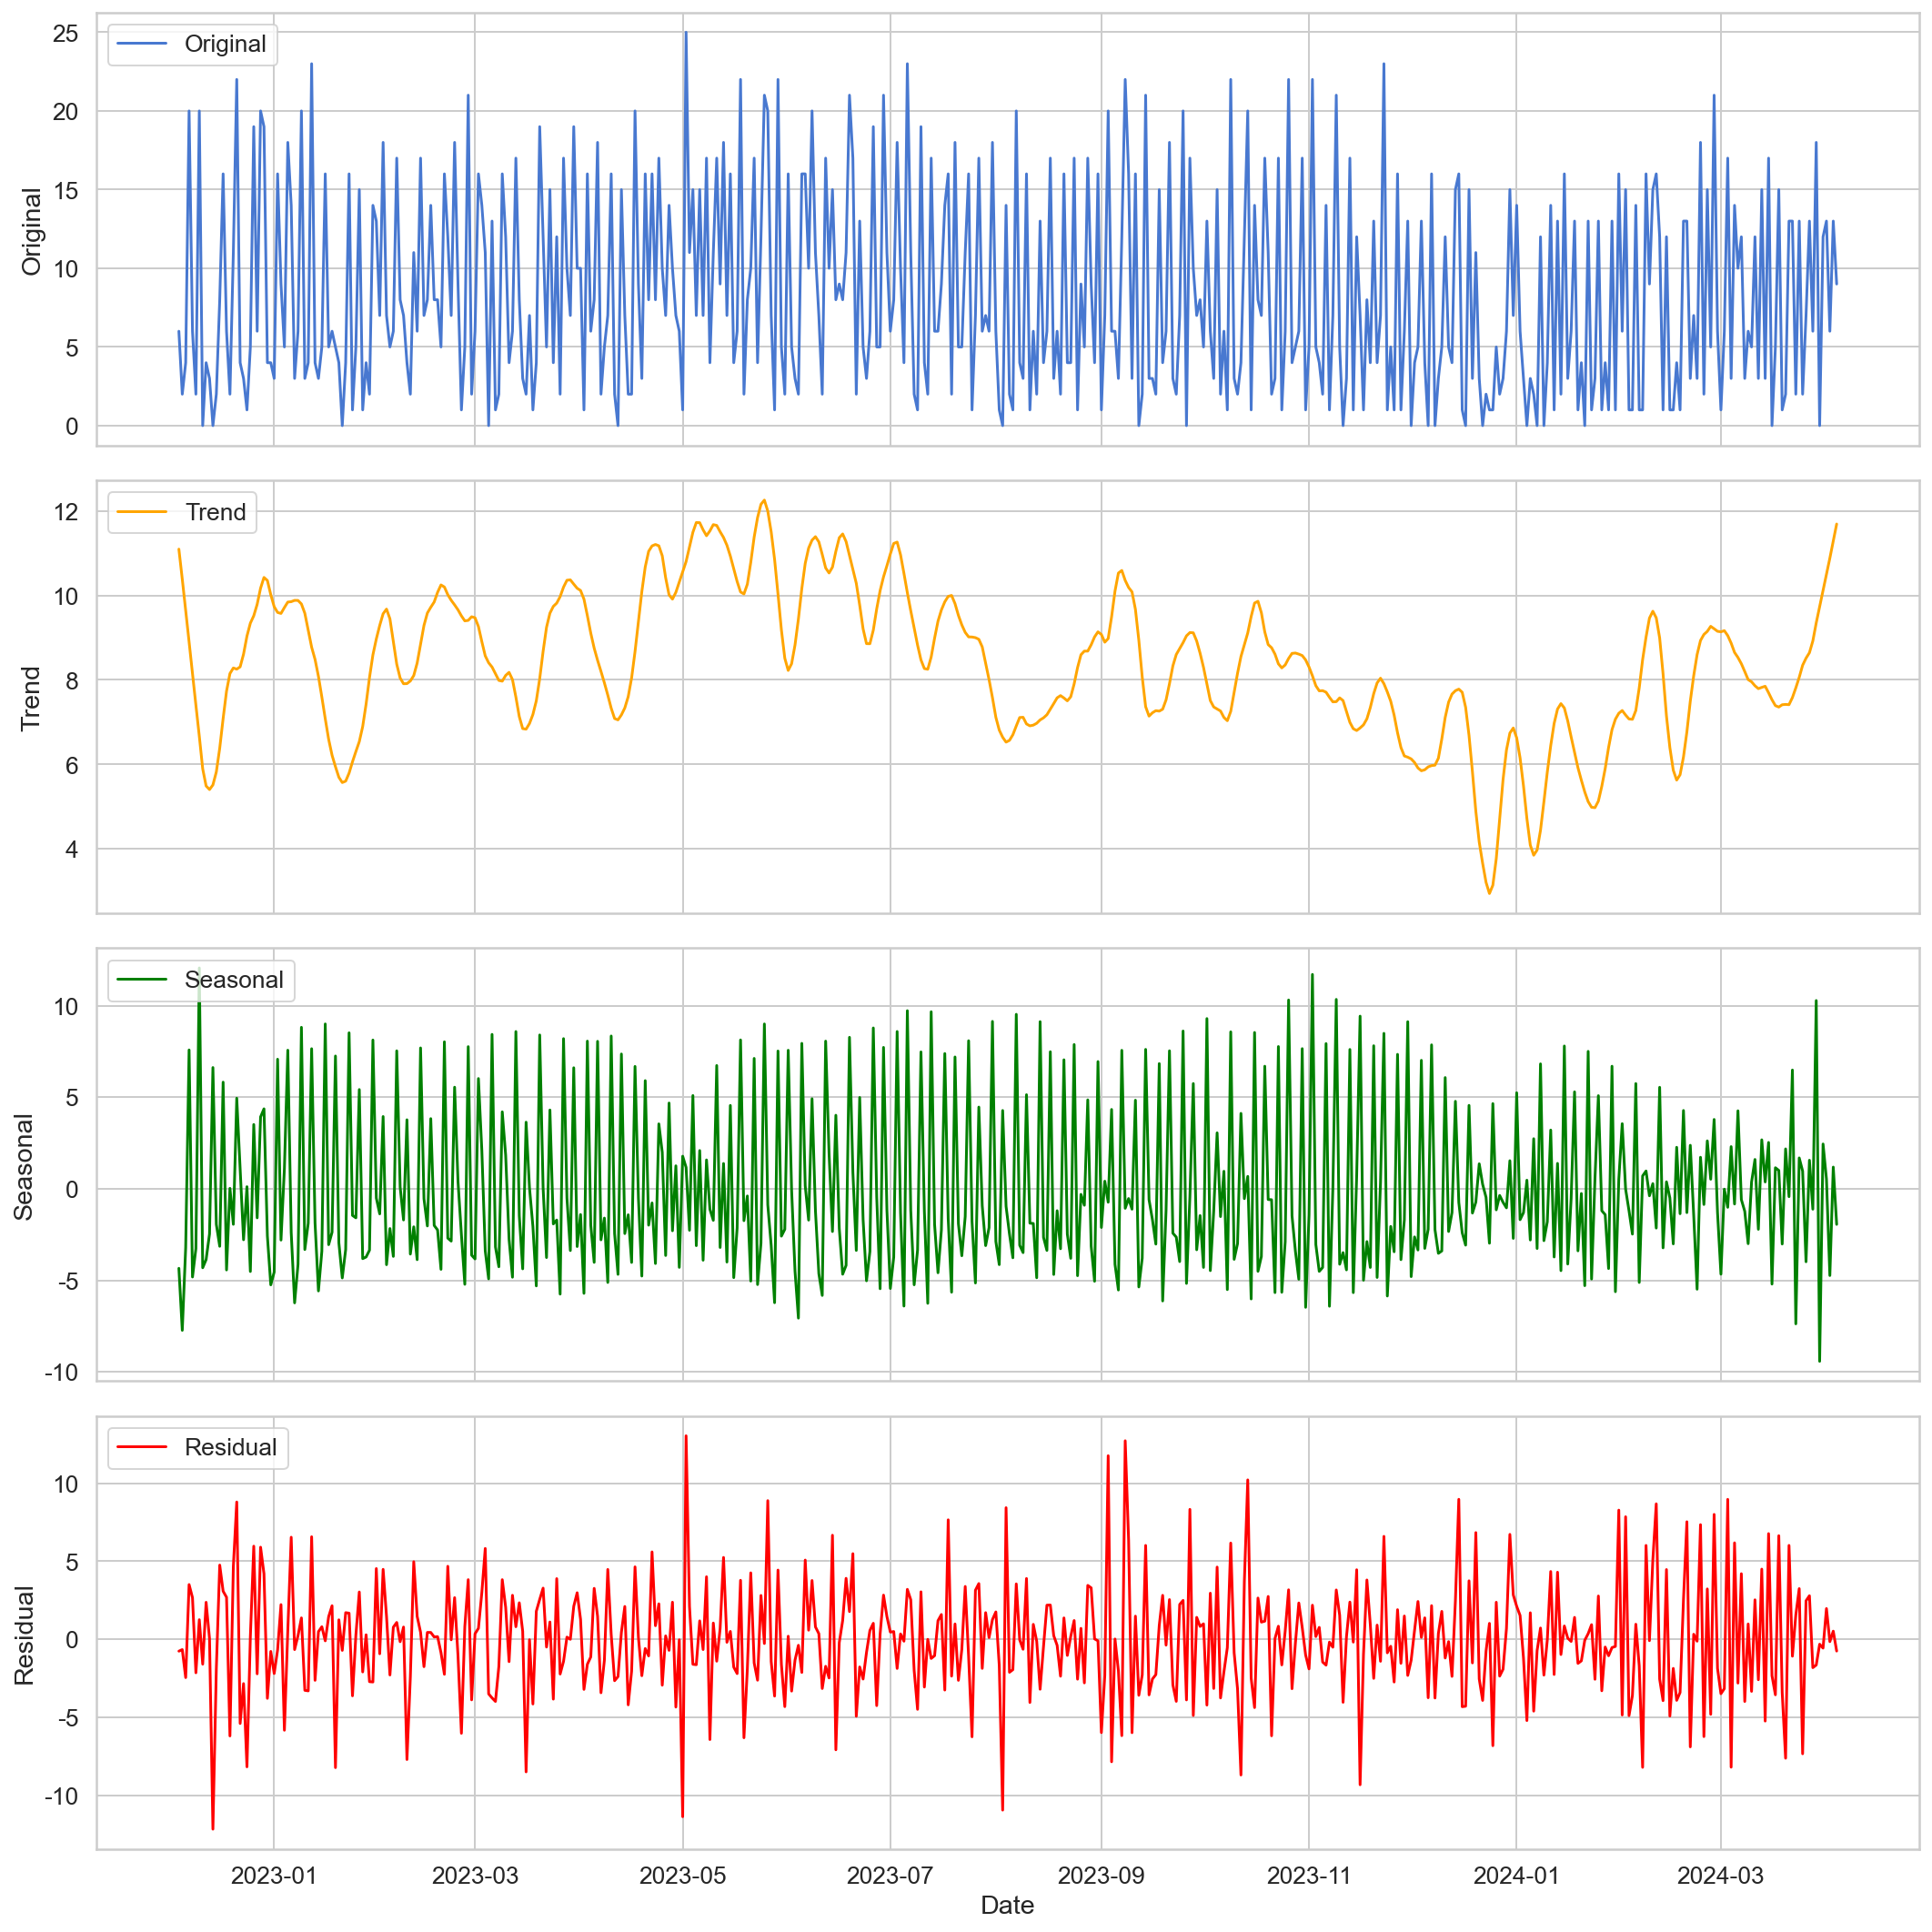

In [73]:
# 결과 그래프
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 15), sharex=True)
ax1.plot(ts, label='Original')
ax1.legend(loc='upper left')
ax1.set_ylabel('Original')

ax2.plot(result.trend, label='Trend', color='orange')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')

ax3.plot(result.seasonal, label='Seasonal', color='green')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')

ax4.plot(result.resid, label='Residual', color='red')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')

plt.xlabel('Date')
plt.tight_layout()
plt.show()